[Warnning] R0: not enough peaks found
[Warnning] R1: not enough peaks found


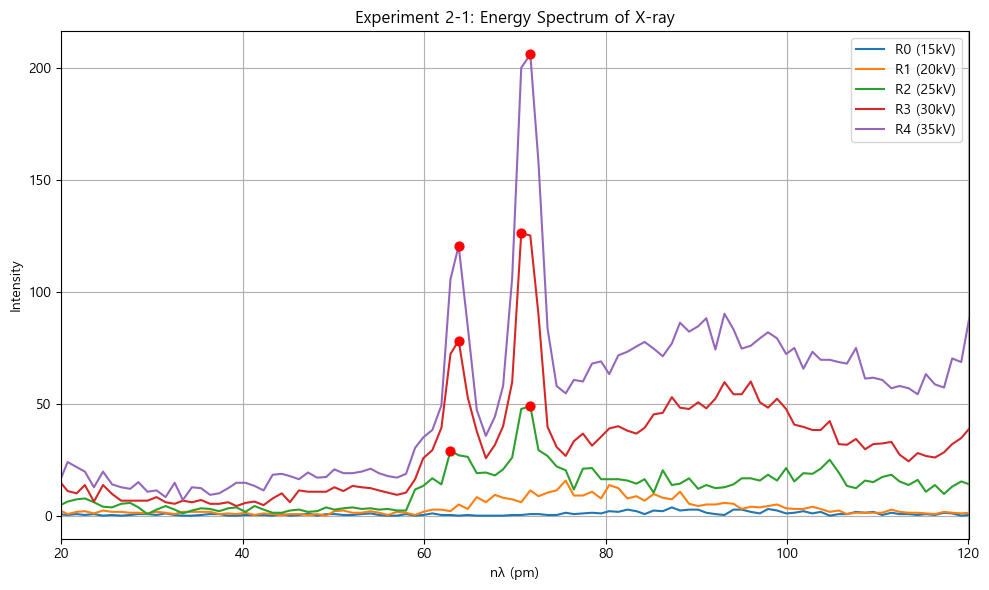

╒═══════════╤══════════╤═════════╤════════════════╤══════════╤══════════════════════╤═════════════════════╤══════════════════════╕
│ Channel   │   U (kV) │ Line    │   Peak nλ (pm) │   Best n │   λ Experimental (Å) │   λ Theoretical (Å) │   Relative Error (%) │
╞═══════════╪══════════╪═════════╪════════════════╪══════════╪══════════════════════╪═════════════════════╪══════════════════════╡
│ R2        │       25 │ K_beta  │        62.9000 │        1 │               0.6290 │              0.6310 │               0.3091 │
├───────────┼──────────┼─────────┼────────────────┼──────────┼──────────────────────┼─────────────────────┼──────────────────────┤
│ R2        │       25 │ K_alpha │        71.7000 │        1 │               0.7170 │              0.7108 │               0.8723 │
├───────────┼──────────┼─────────┼────────────────┼──────────┼──────────────────────┼─────────────────────┼──────────────────────┤
│ R3        │       30 │ K_beta  │        63.8000 │        1 │               0.6380

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from tabulate import tabulate
from matplotlib import rcParams

# 한글 폰트 설정 (Windows)
rcParams['font.family'] = 'Malgun Gothic'
rcParams['axes.unicode_minus'] = False

# load data
file_path = '실험2_전체데이터_교정완료_v2.csv'
data = pd.read_csv(file_path)


# channel map (X-ray tube channel)
channel_map = {
    'R0': 15,
    'R1': 20,
    'R2': 25,
    'R3': 30,
    'R4': 35
}

# theoretical lambda
lambda_theoretical = {
    "K_alpha": 0.71080,
    "K_beta": 0.63095
}

# relative error
def relative_error(exp, theo):
    return abs(exp - theo) / theo * 100

# finder best n (not necessary)
def find_best_n_lambda(n_lambda_pm, label, max_n=10):
    best_lambda = None
    best_n = None
    min_error = float('inf')
    for n in range(1, max_n + 1):
        lam = n_lambda_pm / n / 100  # pm → Å
        error = relative_error(lam, lambda_theoretical[label])
        if error < min_error:
            min_error = error
            best_lambda = lam
            best_n = n
    return best_lambda, best_n, min_error

results = []

# set figure size
plt.figure(figsize=(10, 6))


for channel, U in channel_map.items():
    intensity = data[channel]
    n_lambda = data['lambda']  # pm

    # data figure
    plt.plot(n_lambda, intensity, label=f'{channel} ({U}kV)')

    # detect peaks
    peak_indices, _ = find_peaks(intensity, prominence=10)
    if len(peak_indices) < 2:
        print(f"[Warnning] {channel}: not enough peaks found")
        continue

    # top 2 peaks
    top2 = peak_indices[np.argsort(intensity.iloc[peak_indices])[-2:]]
    top2 = sorted(top2, key=lambda i: n_lambda.iloc[i])  # sorting
    labels = ["K_beta", "K_alpha"]

    for i, peak_idx in enumerate(top2):
        peak_nlambda = n_lambda.iloc[peak_idx]
        peak_intensity = intensity.iloc[peak_idx]

        # find best n (not necessary)
        lam_exp, best_n, err = find_best_n_lambda(peak_nlambda, labels[i])
        lam_theo = lambda_theoretical[labels[i]]

        results.append([
            channel, U, labels[i],
            round(peak_nlambda, 2), best_n,
            round(lam_exp, 5), lam_theo, round(err, 4)
        ])

        # plot peak
        plt.scatter(peak_nlambda, peak_intensity, color='red', s=40, zorder=5)

# graph settings
plt.title('Experiment 2-1: Energy Spectrum of X-ray')
plt.xlabel('nλ (pm)')
plt.xlim(20, 120)
plt.ylabel('Intensity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# results DataFrame
headers = [
    "Channel", "U (kV)", "Line",
    "Peak nλ (pm)", "Best n",
    "λ Experimental (Å)", "λ Theoretical (Å)", "Relative Error (%)"
]
print(tabulate(results, headers=headers, tablefmt="fancy_grid", floatfmt=".4f"))
